In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import imutils

SELECT FILE

In [8]:
# filename = '23-07-28_schlieren-01_fluoro-3to3mm-602ccm.MP4'
# filename = '23-07-28_schlieren-02_fluoro-3to2mm-666ccm.MP4'
# filename = '23-07-28_schlieren-03_fluoro-2to3mm-593ccm.MP4'
# filename = '23-07-28_schlieren-04_fluoro-1to3mm-1067ccm.MP4'
# filename = '23-07-28_schlieren-05_fluoro-3to1mm-1084ccm.MP4'
# filename = '23-07-28_schlieren-06_fluoro-3to1mm-417ccm.MP4'
# filename = '23-07-28_schlieren-07_fluoro-1to3mm-417ccm.MP4'
# filename = '23-07-28_schlieren-08_fluoro-3to3mm-573ccm-flow-989ccm-purge.MP4'
# filename = '23-07-28_schlieren-09_fluoro-3to3mm-906ccm-flow-599ccm-purge.MP4'
filename = '23-07-28_schlieren-10_fluoro-3to3mm-959ccm-flow-550ccm-purge.MP4'

In [9]:
path = 'data/' + filename
capture = cv.VideoCapture(path)

CROP FRAME

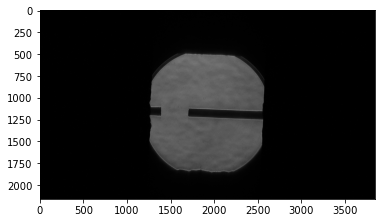

In [10]:
ret, frame = capture.read()
grey_frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

plt.imshow(grey_frame, cmap='gray', vmin=0, vmax=255)
plt.show()

def show_frame(frame): # return plt
    plt.figure(figsize=(10,10))
    plt.imshow(frame, cmap='gray', vmin=0, vmax=255) # on scale 0-255! 
    return plt

def rgb2grey(frame): # return float
    return np.array(cv.cvtColor(frame, cv.COLOR_RGB2GRAY), dtype='float')

(1500, 1500)


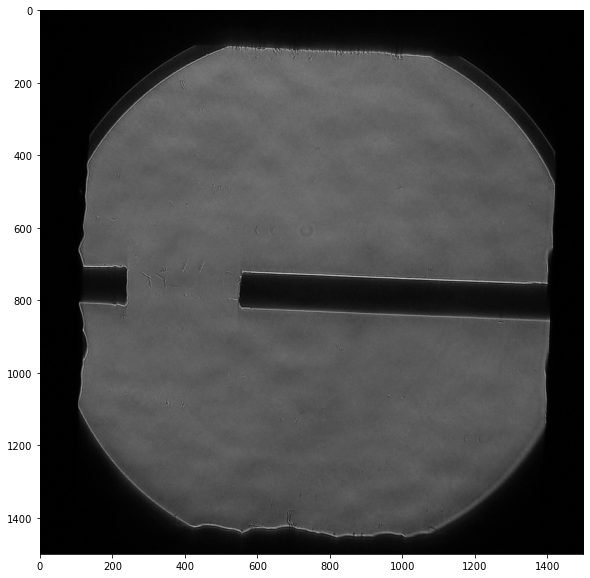

In [11]:
x_crop, y_crop = (1150, 2650), (400,1900) # set

def crop(frame, x, y):
    return frame[ y[0]:y[1], x[0]:x[1]]

crop_frame = crop(grey_frame,x_crop,y_crop)
show_frame(crop_frame)
print(np.shape(crop_frame))

(1500, 1500)


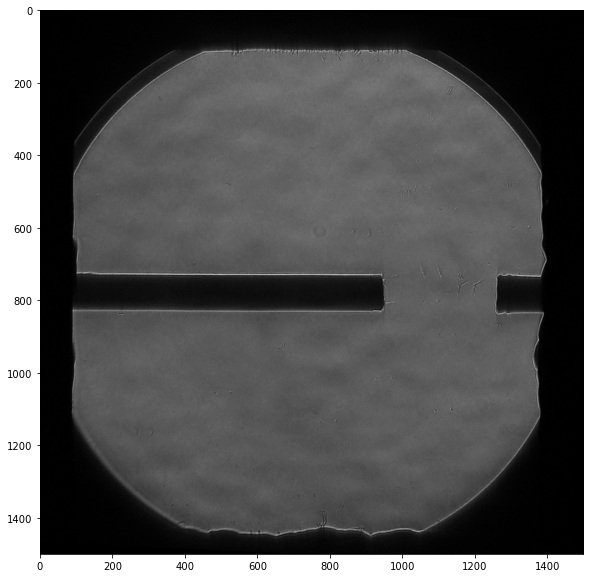

In [12]:
flip = True # set
angle = 2.5 # set
def rot(frame, angle):
    return imutils.rotate(frame, angle = angle)

def flip_y(frame):
    return cv.flip(frame,1)

rot_frame = rot(crop_frame,angle)
flip_frame = flip_y(rot_frame) if flip else rot_frame
show_frame(flip_frame)
FRAME_WIDTH = np.shape(flip_frame)[0]
FRAME_HEIGHT = np.shape(flip_frame)[1]
print(np.shape(flip_frame))

SELECT FRAMES

In [13]:
X_CROP = x_crop
Y_CROP = y_crop
ANGLE = angle
FLIP = flip
def get_frames(capture):
    frames = []
    while True:
        ret, frame = capture.read() 
        if frame is None:
            break
        frame = rgb2grey(frame)
        frame = crop(frame, X_CROP, Y_CROP)
        frame = rot(frame, ANGLE)
        frame = flip_y(frame) if FLIP else frame
        frames.append(frame)
    capture.release()
    return frames

In [14]:
frames = get_frames(capture)
len(frames)

1115

Scan

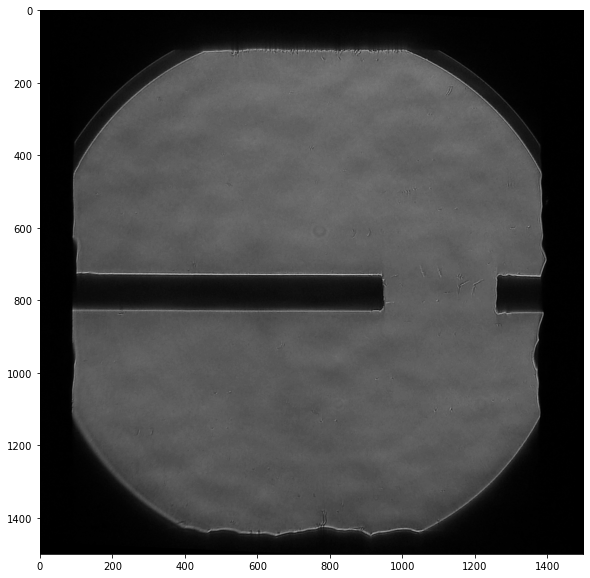

In [15]:
n = 120 # set start
plt = show_frame(frames[n])
plt.show()

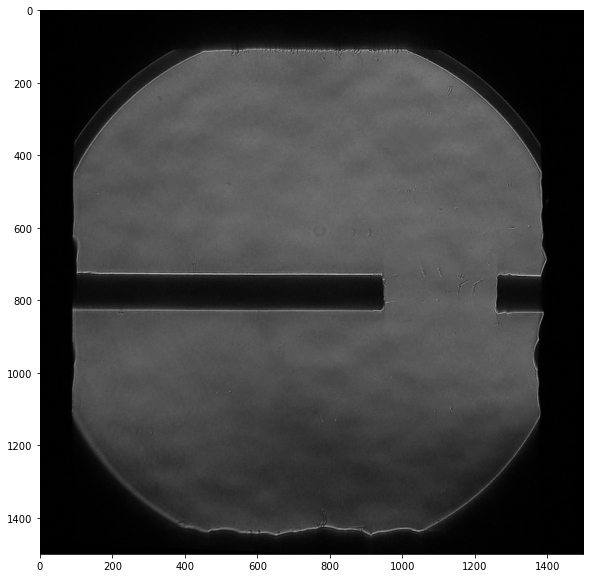

In [16]:
clip_seconds = 41 # set length
Nmax = 24*clip_seconds + n 
plt = show_frame(frames[Nmax])
plt.show()

In [17]:
background_frames = frames[:2*24] # 2s
flow_frames = frames[n:Nmax+1] # n inclusive, Nmax exclusive

In [18]:
print('background frames: ' + str(len(background_frames)))
print('flow frames: ' + str(len(flow_frames)))

background frames: 48
flow frames: 985


PROCESS FRAMES

In [19]:
def average_frames(frames):
    return np.average(frames, axis = 0)

avg_background = average_frames(background_frames)

Background Subtract – Check Frame

In [20]:
def show_frames(frame1, frame2): # on scale 0-255! returns plt
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(frame1, cmap= 'gray', vmin=0, vmax=255)
    ax[1].imshow(frame2, cmap= 'gray', vmin=0, vmax=255)
    fig.set_size_inches(20,10)
    fig.patch.set_facecolor('white')
    plt.tight_layout(pad=2.5, w_pad=2.5, h_pad=5)
    return plt 

In [21]:
def LCSpx(frame, val_min, val_max): # pixel linear contrast stretch between min, max
    ratio = (val_max - val_min)/(np.max(frame) - np.min(frame))
    frame = (frame - np.min(frame))*ratio + val_min
#     return np.rint(frame) # round back after stretch without loosing information!
    return frame

def mirrorpx(frame):
    return np.abs(frame)

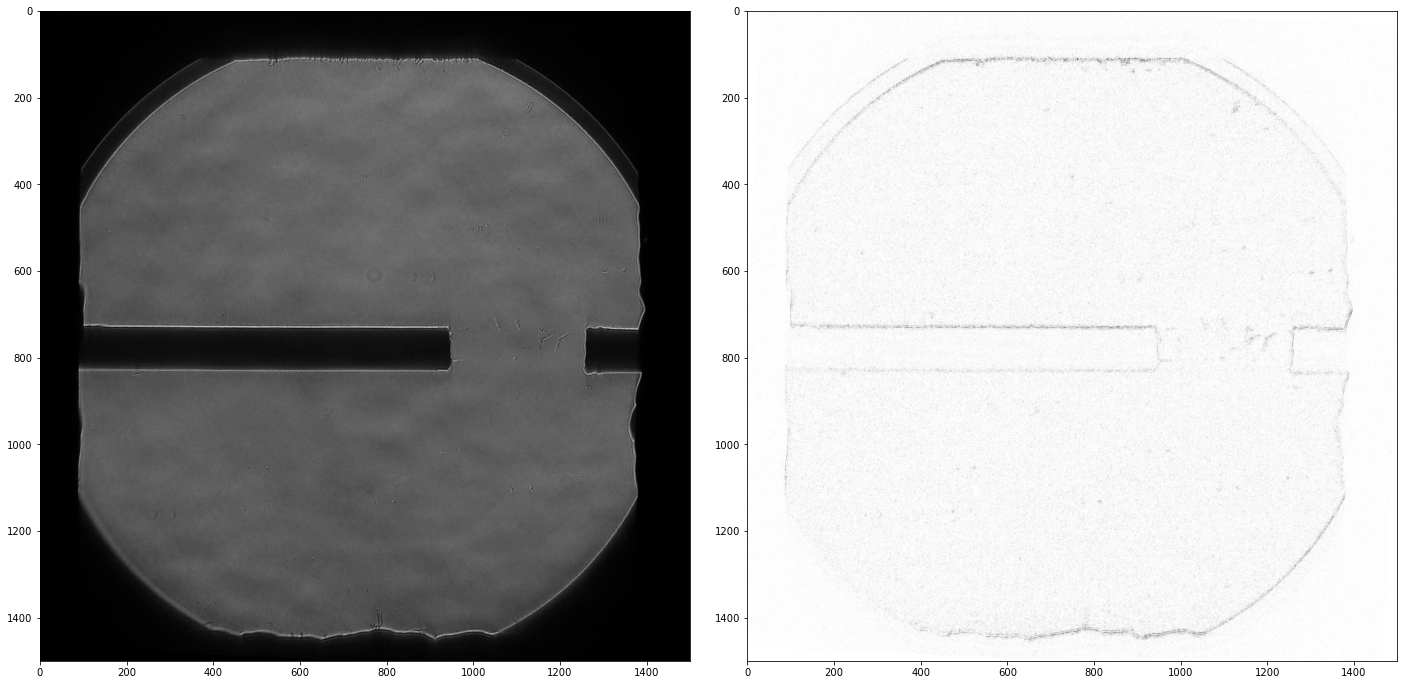

In [22]:
ii = 0 # set check frame
check = flow_frames[ii]

def process(frame, background, invert = False, stretch = False, mirror=False):
    out = frame - avg_background
    out = mirrorpx(out) if mirror else out # mirror ?
    out = LCSpx(out, 0, 255) if stretch else out # LCS ?
    out = 255-out if invert else out # invert?
    return out

invert = True # Set processing
stretch = True
mirror = True
plt = show_frames(check, process(check, avg_background, invert = invert, stretch = stretch, mirror=mirror))                
plt.show()

Background Subtract – out.avi

In [23]:
processed_frames = [process(frame, avg_background, invert=invert, stretch=stretch, mirror=mirror) 
                    for frame in flow_frames]

In [24]:
out = cv.VideoWriter('out.avi',cv.VideoWriter_fourcc('M','J','P','G'), 24, (FRAME_WIDTH,FRAME_HEIGHT), 0)

for frame in processed_frames:
    frame = np.array(np.rint(frame), dtype='uint8')
    out.write(frame)   
out.release()
cv.destroyAllWindows()

Average Background Subtract – processed.png

In [ ]:
process_average = False

In [ ]:
def sum_frames(frames):
    return np.sum(frames, axis=0)

processed = False
if process_average:
    flow_sum = sum_frames(flow_frames)
    sum_subtracted_frame = LCSpx(sum_frames(processed_frames), 0, 255)
    processed = True

In [ ]:
if processed:
    plt = show_frames(LCSpx(flow_sum, 0,255), sum_subtracted_frame)   
    plt.savefig('processed.png', dpi=800)